In [2]:
! pip install tensorflow

  Using cached astunparse-1.6.3-py2.py3-none-any.whl.metadata (4.4 kB)
  Using cached google_pasta-0.2.0-py3-none-any.whl.metadata (814 bytes)
  Using cached libclang-18.1.1-py2.py3-none-win_amd64.whl.metadata (5.3 kB)
  Using cached opt_einsum-3.4.0-py3-none-any.whl.metadata (6.3 kB)
  Using cached tensorboard_data_server-0.7.2-py3-none-any.whl.metadata (1.1 kB)
   ---------------------------------------- 0.0/332.0 MB ? eta -:--:--
   - -------------------------------------- 10.7/332.0 MB 53.3 MB/s eta 0:00:07
   --- ------------------------------------ 25.4/332.0 MB 61.0 MB/s eta 0:00:06
   --- ------------------------------------ 30.4/332.0 MB 48.5 MB/s eta 0:00:07
   ---- ----------------------------------- 34.1/332.0 MB 40.6 MB/s eta 0:00:08
   ---- ----------------------------------- 37.5/332.0 MB 37.1 MB/s eta 0:00:08
   ---- ----------------------------------- 41.4/332.0 MB 32.8 MB/s eta 0:00:09
   ----- ---------------------------------- 45.1/332.0 MB 30.4 MB/s eta 0:00:10
   

# importing library

In [6]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt
import os


In [8]:
dataset = (r"C:\Users\lakshita\Downloads\archive 5")

In [9]:
# Dataset path (change ONLY if needed)
DATASET_DIR = dataset

TRAIN_DIR = os.path.join(DATASET_DIR, "train")
TEST_DIR  = os.path.join(DATASET_DIR, "test")

IMG_SIZE = (224, 224)
BATCH_SIZE = 32
EPOCHS = 10


In [10]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2   # 80% train, 20% validation
)

test_datagen = ImageDataGenerator(rescale=1./255)


In [11]:
train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    subset='training',
    classes=['ai', 'real']   # ai = 0, real = 1
)

val_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    subset='validation',
    classes=['ai', 'real']
)

test_generator = test_datagen.flow_from_directory(
    TEST_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False,
    classes=['ai', 'real']
)


Found 40000 images belonging to 2 classes.
Found 10000 images belonging to 2 classes.
Found 10000 images belonging to 2 classes.


In [12]:
base_model = MobileNetV2(
    weights='imagenet',
    include_top=False,
    input_shape=(224, 224, 3)
)

base_model.trainable = False  # Freeze base model

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(1, activation='sigmoid')(x)

model = Model(inputs=base_model.input, outputs=output)


In [13]:
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 2,422,081 (9.24 MB)

 Trainable params: 164,097 (641.00 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [14]:
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

checkpoint = ModelCheckpoint(
    "best_cifake_model.h5",
    monitor='val_loss',
    save_best_only=True
)


In [15]:
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=EPOCHS,
    callbacks=[early_stop, checkpoint]
)


Epoch 1/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9992 - loss: 0.0018

1250/1250 ━━━━━━━━━━━━━━━━━━━━ 2152s 2s/step - accuracy: 0.9999 - loss: 2.3898e-04 - val_accuracy: 1.0000 - val_loss: 8.5407e-11
Epoch 2/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 1.0000 - loss: 4.5124e-09

1250/1250 ━━━━━━━━━━━━━━━━━━━━ 1771s 1s/step - accuracy: 1.0000 - loss: 4.4731e-09 - val_accuracy: 1.0000 - val_loss: 5.2292e-11
Epoch 3/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 1.0000 - loss: 3.5537e-09

1250/1250 ━━━━━━━━━━━━━━━━━━━━ 1812s 1s/step - accuracy: 1.0000 - loss: 3.2968e-09 - val_accuracy: 1.0000 - val_loss: 3.3824e-11
Epoch 4/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 1.0000 - loss: 5.3112e-09

1250/1250 ━━━━━━━━━━━━━━━━━━━━ 2757s 2s/step - accuracy: 1.0000 - loss: 5.2199e-09 - val_accuracy: 1.0000 - val_loss: 5.4862e-12
Epoch 5/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 1.0000 - loss: 1.5466e-09

1250/1250 ━━━━━━━━━━━━━━━━━━━━ 3202s 3s/step - accuracy: 1.0000 - loss: 1.4757e-09 - val_accuracy: 1.0000 - val_loss: 3.8350e-12
Epoch 6/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 3003s 2s/step - accuracy: 1.0000 - loss: 1.0031e-09 - val_accuracy: 1.0000 - val_loss: 3.8444e-12
Epoch 7/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 43966s 35s/step - accuracy: 1.0000 - loss: 5.6905e-10 - val_accuracy: 1.0000 - val_loss: 7.4864e-12
Epoch 8/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 1.0000 - loss: 5.5846e-10

1250/1250 ━━━━━━━━━━━━━━━━━━━━ 1913s 2s/step - accuracy: 1.0000 - loss: 4.8871e-10 - val_accuracy: 1.0000 - val_loss: 1.2655e-12
Epoch 9/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 1.0000 - loss: 6.2880e-10

1250/1250 ━━━━━━━━━━━━━━━━━━━━ 2006s 2s/step - accuracy: 1.0000 - loss: 5.7667e-10 - val_accuracy: 1.0000 - val_loss: 1.1434e-12
Epoch 10/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 1.0000 - loss: 4.5728e-10

1250/1250 ━━━━━━━━━━━━━━━━━━━━ 1778s 1s/step - accuracy: 1.0000 - loss: 3.4056e-10 - val_accuracy: 1.0000 - val_loss: 1.1098e-12


In [17]:
test_loss, test_acc = model.evaluate(test_generator)
print(f"Test Accuracy: {test_acc * 100:.2f}%")


313/313 ━━━━━━━━━━━━━━━━━━━━ 231s 738ms/step - accuracy: 1.0000 - loss: 1.3699e-11
Test Accuracy: 100.00%


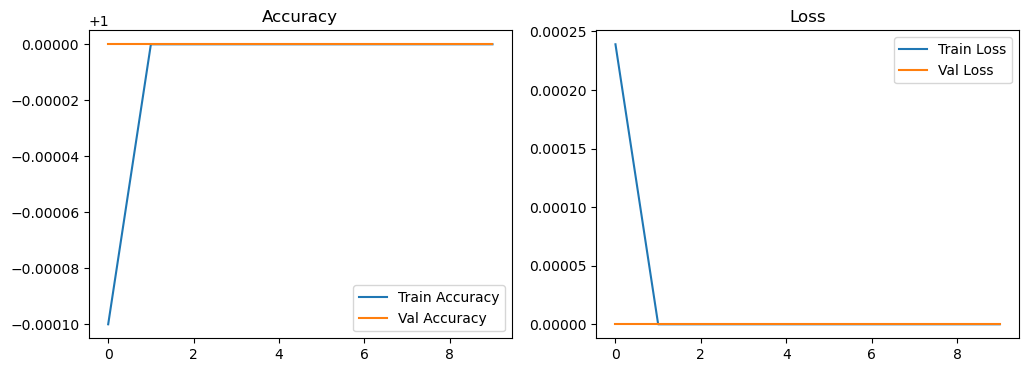

In [22]:
plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.legend()
plt.title("Accuracy")

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.title("Loss")

plt.show()


In [23]:
model.save("real_vs_ai_cifake_final.h5")
print("Model saved successfully!")


Model saved successfully!


In [24]:
import numpy as np
from tensorflow.keras.preprocessing import image

img_path = (r"C:\Users\lakshita\Downloads\image.jpeg")  # change image name

img = image.load_img(img_path, target_size=IMG_SIZE)
img_array = image.img_to_array(img) / 255.0
img_array = np.expand_dims(img_array, axis=0)

prediction = model.predict(img_array)

if prediction[0][0] > 0.5:
    print("Prediction: REAL image")
else:
    print("Prediction: AI-generated image")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step
Prediction: REAL image


In [25]:
pip install flask tensorflow pillow flask-cors


Note: you may need to restart the kernel to use updated packages.
